# Ballon Dataset을 활용한 객체 인식기 개발 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Drive 마운트 
# 학습에 사용할 데이터를 본인의 Drive에 업로드하고 해당 위치를 적어주기 

# -qq : unzip 과정에서 나오는 zip log들이 나오지 않도록 해주는 옵션 
!unzip -qq drive/MyDrive/ai/object_detection_dataset.zip -d . 
!rm -r __MACOSX

replace ./balloon_test1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./balloon_test2.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import os 
import cv2
import json
from PIL import Image, ImageDraw
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import pycocotools.coco as coco
from pycocotools.cocoeval import COCOeval
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
## Hyper-parameters

# 모델 관련 
num_classes = 2

# 학습 세팅 관련 
num_epochs = 10
batch_size = 6
eval_per_step = 5
eval_per_epoch = 5

# 옵티마이저 
learning_rate = 0.005
momentum = 0.9
weight_decay = 5e-4

In [ ]:
class cocoDataset(Dataset):
    def __init__(self, mode):
        super(cocoDataset, self).__init__()
        self.mode = mode # 'train' or 'val'

        self.image_folder = self.mode
        self.annotation_path = f'{self.mode}_balloon.json'

        self.transform = transforms.Compose([
                            transforms.ToTensor(),
                        ])

        self.max_objs = 128
        self.class_name = ['__background__', 'ballon']
        self._valid_ids = [1]


        print('==> initializing {} data.'.format(self.mode))
        self.coco = coco.COCO(self.annotation_path)
        self.images = self.coco.getImgIds()
        self.num_samples = len(self.images)

        print('Loaded {} {} samples'.format(self.mode, self.num_samples))
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, index):
        img_id = self.images[index]
        file_name = self.coco.loadImgs(ids=[img_id])[0]['file_name']
        img_path = os.path.join(self.image_folder, file_name)
        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ids=ann_ids)
        num_objs = min(len(anns), self.max_objs)
    
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        boxes = [] 
        for i in range(num_objs):
            ann = anns[i]
            box = ann['bbox'] # x1, y1, w, h
            if box[2] <= 0 or box[3] <= 0 : 
                continue 
            box = np.array([box[0], box[1], box[0] + box[2], box[1] + box[3]],
                    dtype=np.float32)
            obj_index = ann['category_id']
            
            boxes.append([obj_index, box])

        return image, boxes, img_id

In [ ]:
def collate(batch):
    # images : [batch_size, channel, height, width]
    # annots : (batch_size) [
    #              [[index, [x1, y1, x2, y2]], [index, [x1, y1, x2, y2]], [index, [x1, y1, x2, y2]]],
    #              [[index, [x1, y1, x2, y2]]],
    #              [[index, [x1, y1, x2, y2]], [index, [x1, y1, x2, y2]]] 
    #          ]
    # image_id : (batch_size) [id1, id2, ... ,idx]
    
    images, annots, image_id = zip(*batch)
    
    batch_size = len(images)
    
    images = list(image for image in images)
    max_obj_num = max(list(len(objs_per_imgs) for objs_per_imgs in annots))

    targets = []
    for i in range(batch_size):
        t = {} 
        t['boxes'] = torch.tensor([0, 0, 1, 1], dtype=torch.float32).repeat(max_obj_num, 1)
        t['labels'] = torch.zeros(max_obj_num, dtype=torch.int64)

        for j in range(len(annots[i])):
            t['boxes'][j] = torch.tensor(annots[i][j][1]) # i : batch, j : obj, 1 : coordinate 
            t['labels'][j] = torch.tensor(annots[i][j][0]) # i : batch, j : obj, 0 : index    
        
        targets.append(t)

    return images, targets, image_id


In [ ]:
train_dataset = cocoDataset(mode='train')
val_dataset = cocoDataset(mode='val')

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, collate_fn=collate)
val_loader = DataLoader(dataset=val_dataset, batch_size=1, num_workers=2, collate_fn=collate)

==> initializing train data.
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loaded train 61 samples
==> initializing val data.
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loaded val 13 samples


In [ ]:
model = None
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                  num_classes=num_classes, # 2 (balloon, background)
                  rpn_anchor_generator=anchor_generator,
                  box_roi_pool=roi_pooler,
                  min_size=500, max_size=600).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

In [ ]:
coco_ = coco.COCO('val_balloon.json') 

def evaluate(model, dataloader): 
    detections = [] 
    for images, targets, image_id in dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        model.eval()
        predictions = model(images)[0] 
        
        for i in range(len(predictions['scores'])):
            if predictions['scores'][i].item() < 0.1 : continue 
            
            img_id         = int(image_id[0])
            category_id    = int(predictions['labels'][i].item())
            score          = float("{:.2f}".format(predictions['scores'][i].item()))
            x1, y1, x2, y2 = predictions['boxes'][i].tolist()
            bbox           = [x1, y1, x2-x1, y2-y1]
            
            detection = {
                "image_id": img_id,
                "category_id": category_id,
                "bbox": bbox,
                "score": score
            }
            detections.append(detection)
    
    json_path = 'results_eval_detections.json'
    json.dump(detections, open(json_path, 'w'))
    coco_dets = coco_.loadRes(json_path)
    coco_eval = COCOeval(coco_, coco_dets, "bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    
    if len(coco_eval.stats) == 0 : 
        return 0.0 
    else : 
        return float(coco_eval.stats[1])

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
loss_arr = []
max_ap = 0.0
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, targets, image_id) in enumerate(train_loader):
        model.train()
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if (i+1) % eval_per_step == 0 :
            loss_arr.append(losses)
            print('Epoch [{}/{}], Step [{}/{}], Losses: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, total_step, losses.item()))
            
    if (epoch+1) % eval_per_epoch == 0 :
        ap = evaluate(model, val_loader)
        if max_ap < ap :
            max_ap = ap
            print('Save model...')
            torch.save(model.state_dict(), f'model.ckpt')

Epoch [1/10], Step [5/11], Losses: 0.7951
Epoch [1/10], Step [10/11], Losses: 0.4487
Epoch [2/10], Step [5/11], Losses: 0.2415
Epoch [2/10], Step [10/11], Losses: 0.4771
Epoch [3/10], Step [5/11], Losses: 0.3234
Epoch [3/10], Step [10/11], Losses: 0.3388
Epoch [4/10], Step [5/11], Losses: 0.3479
Epoch [4/10], Step [10/11], Losses: 0.2356
Epoch [5/10], Step [5/11], Losses: 0.3767
Epoch [5/10], Step [10/11], Losses: 0.2521
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 |

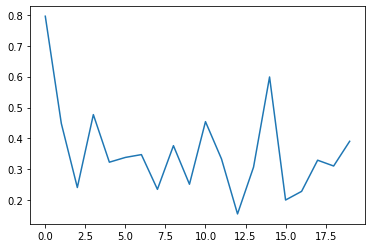

In [ ]:
plt.plot(loss_arr)
plt.show()

# FasterRCNN 모델 선언(미리 학습된 데이터 사용)

In [ ]:
def load_FasterRCNN(ckpt_path, device):
    backbone = torchvision.models.mobilenet_v2(pretrained=True).features
    backbone.out_channels = 1280
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                    aspect_ratios=((0.5, 1.0, 2.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)

    model = FasterRCNN(backbone,
                    num_classes=num_classes, # 2 (balloon, background)
                    rpn_anchor_generator=anchor_generator,
                    box_roi_pool=roi_pooler,
                    min_size=500, max_size=600).to(device)
    model.load_state_dict(torch.load(ckpt_path))
    return model 

In [ ]:
model = load_FasterRCNN('drive/MyDrive/ai/FasterRCNN_balloon.ckpt', device)

In [ ]:
def test(model, image_path, device):
    model.eval()
    
    PIL_image = Image.open(image_path).convert("RGB")
    image = transforms.Compose([transforms.ToTensor()])(PIL_image)
    image = [image.to(device)]
    
    predictions = model(image)[0] 

    cv_image = cv2.imread(image_path)
    for i in range(len(predictions['scores'])):
        scr = predictions['scores'][i].item()
        if scr < 0.5 : continue 
        x1, y1, x2, y2 = predictions['boxes'][i].tolist()
        cv_image = cv2.rectangle(cv_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255))
        cv_image = cv2.putText(cv_image, f'{scr:0.2f}', (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    cv2.imwrite('test_results.jpg', cv_image)

In [ ]:
test(model, 'balloon_test1.jpg', device)

결과값(jpg 파일)은 readme.md 파일을 참조하길 바랍니다.